# Sampler Implementations

In [1]:
from IPython.display import clear_output

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st

plt.style.use("fivethirtyeight")

## Table of Contents

[Rejection Sampling](#Rejection-Sampling)
1. [Beginning Notes](#Beginning-Notes-About-Rejection-Sampling)
1. [Beta Distribution](#Beta-Distribution)
1. [Walkthrough](#Rejection-Sampling-Walkthrough)
1. [Implementation](#Rejection-Sampling-Implementation)
1. [Ending Notes](#Ending-Notes-About-Rejection-Sampling)

[Metropolis-Hastings](#Metropolis-Hastings)

1. [Beginning Notes](#Beginning-Notes-About-Metropolis-Hastings)
1. [Walkthrough](#Metropolis-Hastings-Walkthrough)
1. [Implementation](#Metropolis-Hastings-Implementation)
1. [Ending Notes](#Ending-Notes-About-Metropolis-Hastings)

[Hamiltonian Monte Carlo](#Hamiltonian-Monte-Carlo)

1. [Beginning Notes](#Beginning-Notes-About-Hamiltonian-Monte-Carlo)
1. [Implementation](#Hamiltonian-Monte-Carlo-Implementation)
1. [Ending Notes](#Ending-Notes-About-Hamiltonian-Monte-Carlo)

## Rejection Sampling

### Beginning Notes About Rejection Sampling

#### Motivation

Integration is difficult. A short reason for this is that when we integrate something we are asking about information across an interval and coming up with the requisite information across that entire thing is difficult/time-consuming. There are a lot more sophisticated answers to this, but  something that is fun to see as an exercise is to implement a reimann sum estimator and then see what happens as you increase the dimensionality of your input function. (Answer: curse of dimensionality... the size of the space explodes very quickly as one increases dimensions).

#### Why do we care about integration?

We don't care explicitly about integration, but we do care about *expectations*.

Let $f(x)$ be a probability distribution. 

Expectations $\mathop{\mathbb{E}}[X]$ (averages, means, variances, etc) are something that we care about a lot a lot (a lot of things that a data scientist cares about can be written as an expectation). 

$\mathop{\mathbb{E}}[X]$ can be written as $\int_{R}xf(x)dx$, which is saying "For each x in X, find out how likely it is and weight the value of it by its likelihood." But remember, "for each x in X" is saying A LOT.

So perhaps we can't say as much about $f(x)$ as $\int_{R}xf(x)dx$ wants us to say. A nifty trick is saying instead, "Okay, we can't say something about every single x in X, but we could say something about 100 x's in X, or a 1,000, or something." So essentially, $\int_Rxf(x)dx$ turns into $\frac{1}{N}\sum_R x f(x)$ where we just take a bunch (10, 100, 1000, etc) of x's that we hope are representative of $f(x)$. As we increase the number of "a bunch" to infinity we approach $\int_Rxf(x)dx$. 

So, 

- "we just take a bunch of x's that we hope are representative of $f(x)$" is **sampling** and
- "as we increase the number of a bunch to infinity we approach $\int_Rxf(x)dx$" is **approximation**.

After we say that sampling is a nice idea, we come to the question "what is the best way to get a representative sample of x's quickly?" and we can begin answering that question with **rejection sampling**. Not a great way to sample, but lays a good foundation for thinking more about sampling.

### Beta Distribution

I'm going to use a beta distribution just because it looks nice, and its bounded between 0 and 1 which might be a nice property (?). 

Some information about a Beta https://en.wikipedia.org/wiki/Beta_distribution

Beta's are defined by:
- two shape parameters $\alpha > 0$ and $\beta > 0$
- the domain [0, 1]

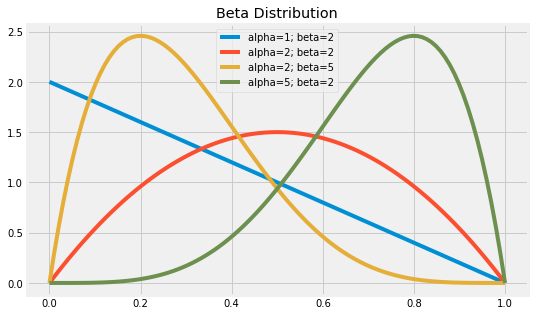

In [2]:
# plot a bunch of betas with different shape parameters
xx = np.linspace(0, 1, 100)  # get a bunch of x's between 0 and 1

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(xx, st.beta.pdf(xx, a=1, b=2), label="alpha=1; beta=2")
ax.plot(xx, st.beta.pdf(xx, a=2, b=2), label="alpha=2; beta=2")
ax.plot(xx, st.beta.pdf(xx, a=2, b=5), label="alpha=2; beta=5")
ax.plot(xx, st.beta.pdf(xx, a=5, b=2), label="alpha=5; beta=2")

ax.set_title("Beta Distribution")
ax.legend();

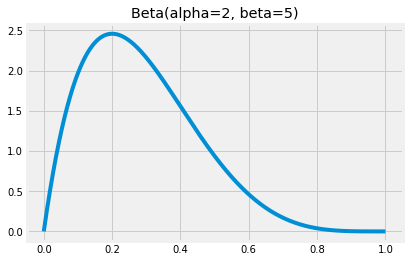

In [3]:
# whenever possible, will probably attempt to use beta(alpha=2, beta=5) as our target, since I think it looks nice

beta = st.beta(a=2, b=5)

xx = np.linspace(0, 1, 1_000)
plt.plot(xx, beta.pdf(xx));
plt.title("Beta(alpha=2, beta=5)");

### Rejection Sampling Walkthrough

We want to define some function which we know bounds our target function.

**Target Function: f(x) = beta(alpha=2, beta=5)  -- blue line above**

From looking at the blue line above (cheating) we can see that the line g(x) = 3 bounds f(x) -- (A way to not cheat is to choose any bounding function g(x), find the max value of f(x) -- call that `k` -- and call our bounding function k*g(x) such that k*g(x) is now strictly greater than or equal to f(x)) -- but we are just going to use g(x) = 3.

**Bounding Function: g(x) = 3**

So now we have two functions f(x) and g(x) where g(x) bounds f(x) over all x. The main property that we want of our bounding function is that (like a uniform distribution) IT IS EASY TO SAMPLE FROM.

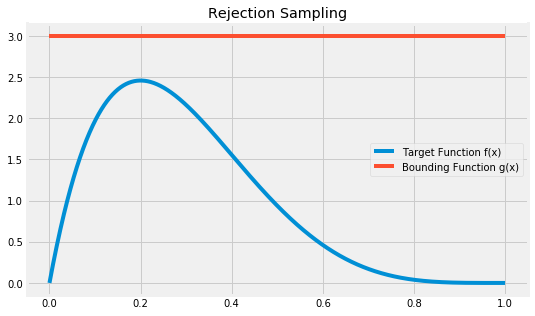

In [4]:
def draw_curves():
    xx = np.linspace(0, 1, 1_000)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.set_title("Rejection Sampling")
    ax.plot(xx, beta.pdf(xx), label="Target Function f(x)")
    ax.plot(xx, np.ones_like(xx) * 3, label="Bounding Function g(x)")
    ax.legend();
    return ax
    
draw_curves();

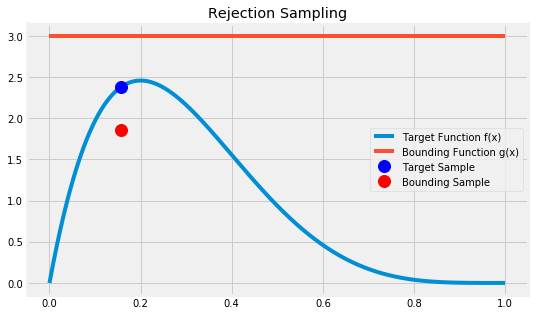

In [5]:
# We know that that domain of f(x) is [0, 1]
# We also know that the range of f(x) is at most g(x) at any x. 

# So, let's propose an x from the uniform(0, 1) -- which is super easy to sample from
g_x = lambda: np.random.uniform(low=0, high=3)
f_x = lambda x: beta.pdf(x)

def propose_and_plot():
    x1 = np.random.uniform(low=0, high=1)  # <- sampling from a uniform
    fx1 = f_x(x1)  # <- evalutating our target function at our sampled x
    gx = g_x()  # <- sampling from our bounding function

    ax = draw_curves();
    ax.plot(x1, fx1, "bo", markersize=12, label="Target Sample")
    ax.plot(x1, gx, "ro", markersize=12, label="Bounding Sample")
    ax.legend();
    return x1, fx1, gx
    
x1, fx1, gx = propose_and_plot();

In [6]:
# We have our sample from our bounding function g(x) -- red dot in the plot above
# If our sample from g(x) is smaller than our f(x) evaluated at our sample x1 -- blue dot in the plot above
# Then we accept that proposal

samples = []
if gx <= fx1:
    print("Accept")
    samples.append(x1)  # add that to our list of samples and do it again!
else:
    print("Reject... try again")

Accept


Accepted: 3
Rejected: 7


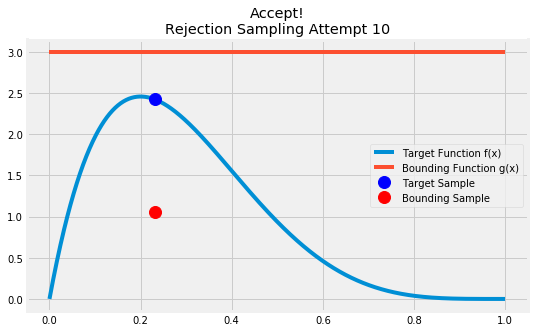

[0.1400799258115094, 0.26985116722944325, 0.2316370969800876]


In [7]:
# We want to run this repeatedly until we have the number of samples that we want
    
num_samples_desired = 3
samples = []
attempt_number = 1

while len(samples) < num_samples_desired:
    clear_output()
    
    # x1 proposal for our domain
    # fx1 f(x) evaluated at our proposed x1
    # gx proposal for our range
    x1, fx1, gx = propose_and_plot();
    
    # accept or reject?
    if gx <= fx1:
        plt.title(f"Accept!\nRejection Sampling Attempt {attempt_number}")
        samples.append(x1)  # add that to our list of samples and do it again!
    else:
        plt.title(f"Reject...\nRejection Sampling Attempt {attempt_number}")
    
    plt.legend();
    print(f"Accepted: {len(samples)}\nRejected: {attempt_number - len(samples)}")
    plt.pause(2)
    attempt_number += 1
    
print(samples)

### Rejection Sampling Implementation

Acceped: 20,000
Rejected: 40,273
CPU times: user 7.51 s, sys: 61.9 ms, total: 7.57 s
Wall time: 7.54 s


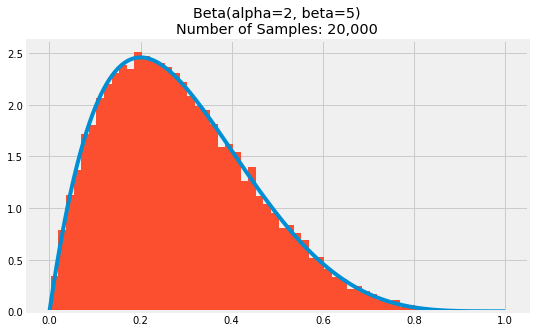

In [9]:
%%time
num_samples_desired = 20_000
samples = []
attempt_number = 1

while len(samples) < num_samples_desired:
    x1 = np.random.uniform(low=0, high=1)
    fx1 = f_x(x1)
    gx1 = g_x()
    
    # accept or reject?
    if gx1 < fx1:
        samples.append(x1)
    attempt_number += 1
    
fig, ax = plt.subplots(figsize=(8, 5))
xx = np.linspace(0, 1, 1_000)
ax.plot(xx, [f_x(x1) for x1 in xx])
ax.hist(samples, bins="auto", density=True)
print(f"Acceped: {len(samples):,}\nRejected: {attempt_number - len(samples):,}")
ax.set_title(f"Beta(alpha=2, beta=5)\nNumber of Samples: {num_samples_desired:,}");

### Ending Notes About Rejection Sampling

From the above plot we notice a couple things

- We reject way more than we accept
    - This is due to the amount of empty space above our target distribution, 
    but below our bounding distribution. As we increase our dimensionality, 
    there is even **more** space here. The larger the space here, the more we
    will reject.
    - We end up rejecting a lot of proposals using this basic rejection sampling
    algorithm
- What we are essentially doing here is using our bounding function g(x) to
sample from our target distribution
- Our samples are our **x-values**
- As we do this more and more, since there is less space above our target function,
but below our bounding function, at `0.2` we should receive more acceptances for 
`x` proposals near `0.2`. This means that our samples of x's at the end should
reflect the weighting of those x's -- f(x)
-  8 seconds to run, not incredible fast...
- The plot looks remarkably similar to an **INTEGRAL!!**

## Metropolis-Hastings

### Beginning Notes About Metropolis-Hastings

We noticed in our vanilla rejection sampler, that we were rejecting a lot of proposals. We also needed to rely on this bounding function which requires additional information about the entire function. In addition, since we were relying on some bounding function, we rejected whenever the proposal from the bounding function was too high, but as we increase dimensions there will be more and more space in this "limbo" area between the bounding function at x and the target function at x, meaning that we would reject more and more often. 

Metropolis-Hastings in another rejection sampling method that improves upon the acceptance probability. 

A way that I think about Metropolis-Hastings is that it is a random walk along the domain of your target function where you stick around more often in areas of higher density and each "step" that we actually take in this walk is a sample. We decide to take a step depending on the relative density of the proposed next step relative to the current one, if its higher then we will take it and if its lower we will sometimes take it depending on how much lower it is.

### Metropolis-Hastings Walkthrough

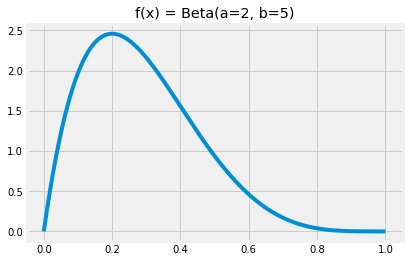

In [10]:
# We begin with our target function
target_distribution = lambda x: st.beta.pdf(a=2, b=5, x=x)

xx = np.linspace(0, 1, 1_000)
plt.plot(xx, [target_distribution(xi) for xi in xx])
plt.title("f(x) = Beta(a=2, b=5)");

In [11]:
# Next we choose a starting point
x_0 = 0.5  # just cause
x_0

0.5

/Users/camen/miniconda3/envs/camen3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1720: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


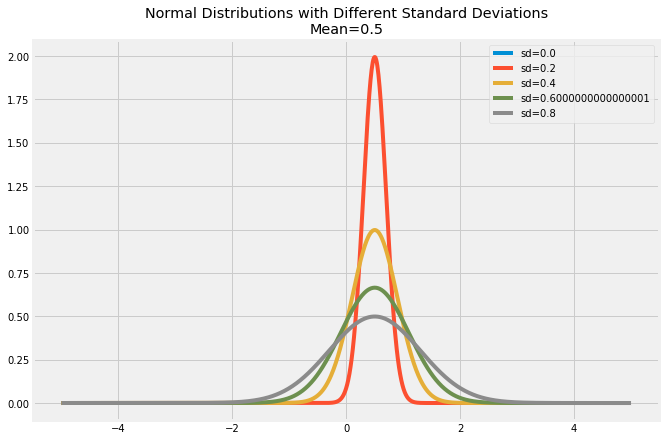

In [12]:
# Now we want to be able to propose the next x given our previous one randomly
# Let's use a normal distribution centered on our starting point
# A normal distribution has 2 parameters, a mean and a standard devitation
# We already chose our mean, but what should our standard deviation be?

fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title(f"Normal Distributions with Different Standard Deviations\nMean={x_0}")
xx = np.linspace(-5, 5, 1_000)

for sd in np.arange(0, 1, 0.2):
    ax.plot(xx, st.norm.pdf(loc=x_0, scale=sd, x=xx), label=f"sd={sd}")

ax.legend();

In [13]:
# We don't really want our next point to move _really_ far from our current point
# so maybe something a little narrower, let's say sd=0.3

proposal_distribution = lambda x: np.random.normal(loc=x, scale=0.3)
proposal = proposal_distribution(x_0)
proposal

# we started at 0.5 and are now proposing to move to this point

0.4586415364745447

In [14]:
# When do we accept this step?

# Well, more frequently we want to move in the direction of higher density
# (where the beta(a=2, b=5) is larger), but we don't _only_ want to move in that
# direction since we also want to explore the tails

# The idea here is to get a ratio of f(x_next) / f(x_previous), and we call this
# the acceptance ratio
acceptance_ratio = target_distribution(proposal) / target_distribution(x_0)

# looking at this ratio it should be greater than 1 if we are moving to an 
# area of higher density, and less than 1 otherwise. So this captures the
# first part (if the proposal is an area of higher density we ALWAYS want
# to move there). But, we still do want to move in the direction of lower
# density _sometimes_. That sometimes is more frequent the larger the
# density of the proposal is. 

if np.random.uniform(low=0, high=1) < acceptance_ratio:
    print("Accept!")

else:
    print("Reject...")

Accept!


In [15]:
# If we accept and do move to the next point we want to now say we are at that next 
# point and run the algorithm again. If we reject, we want to stay at the same 
# point and make a new proposal.

if np.random.uniform(low=0, high=1) < acceptance_ratio:
    print("Accept!")
    x_next = proposal

else:
    print("Reject...")
    x_next = x_0

Accept!


In [16]:
# We we wand to run this over and over until we retrieve the number of samples that 
# we want.

Accepted: 10
Rejected: 15


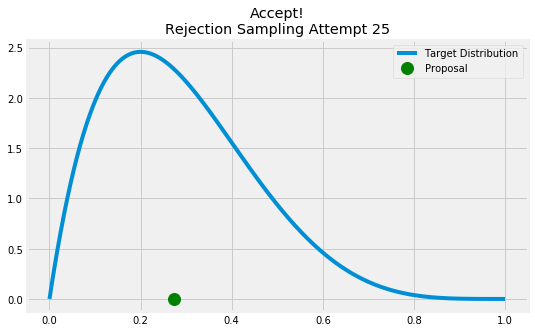

[0.15240753961988562, 0.15240753961988562, 0.15240753961988562, 0.15240753961988562, 0.15240753961988562, 0.15240753961988562, 0.15240753961988562, 0.15240753961988562, 0.15240753961988562, 0.15240753961988562]


In [18]:
# We want to run this repeatedly until we have the number of samples that we want

proposal_distribution = lambda x: np.random.normal(loc=x, scale=0.3)
target_distribution = lambda x: st.beta.pdf(a=2, b=5, x=x)


num_samples_desired = 10
samples = []
num_attempts = 1
x_current = 0.5
while len(samples) < num_samples_desired:
    clear_output()
    
    num_attempts += 1
        
    fig, ax = plt.subplots(figsize=(8, 5))
    xx = np.linspace(0, 1, 1_000)
    ax.plot(xx, [target_distribution(xi) for xi in xx], label="Target Distribution")
    
    x_proposal = proposal_distribution(x_current)
    ax.plot(x_proposal, 0, "go", markersize=12, label="Proposal")
    
    acceptance_ratio = target_distribution(x_proposal) / target_distribution(x_current)
    uniform_sample = np.random.uniform(low=0, high=1)
    
    # accept or reject?
    if uniform_sample <= acceptance_ratio:
        plt.title(f"Accept!\nRejection Sampling Attempt {attempt_number}")
        x_current = x1
    
    else:
        plt.title(f"Reject...\nRejection Sampling Attempt {attempt_number}")

    samples.append(x_current)
    
    print(f"Accepted: {len(samples)}\nRejected: {attempt_number - len(samples)}")
    ax.legend()
    plt.pause(2)
    attempt_number += 1
    
print(samples)

### Metropolis-Hastings Implementation

Accepted: 20,000
Rejected: 18,905
CPU times: user 11.6 s, sys: 92.7 ms, total: 11.7 s
Wall time: 11.8 s


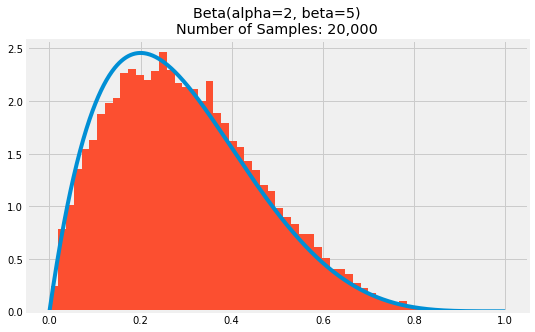

In [99]:
%%time
num_desired_samples = 20_000
x0 = 0.5  # initial x
proposal_distribution = lambda x: np.random.normal(loc=x, scale=0.3)  # proposal
target_distribution = lambda x: beta.pdf(x)  # target

samples = []
num_attempts = 1
while len(samples) < num_desired_samples:
    
    x1 = proposal_distribution(x0)
    acceptance_ratio = target_distribution(x1) / target_distribution(x0)
    uniform_sample = np.random.uniform(low=0, high=1)
    
    num_attempts += 1
    
    if uniform_sample <= acceptance_ratio:
        samples.append(x1)
        x0 = x1

fig, ax = plt.subplots(figsize=(8, 5))
xx = np.linspace(0, 1, 1_000)
ax.plot(xx, [f_x(xi) for xi in xx])
print(f"Accepted: {len(samples):,}\nRejected: {num_attempts - len(samples):,}")
ax.hist(samples, bins="auto", density=True);
ax.set_title(f"Beta(alpha=2, beta=5)\nNumber of Samples: {len(samples):,}")

### Ending Notes About Metropolis-Hastings

From the above plot we notice a couple things

- We reject around as much as we accept
    - This is a lot better than our vanilla rejection sampling earlier!
- We don't need a bounding function
- The histogram of our samples doesn't completely resemble our target function,
but it's close
- 10 seconds, a bit slower than our vanilla rejection sampler

## Hamiltonian Monte Carlo

### Beginning Notes About Hamiltonian Monte Carlo

### Hamiltonian Monte Carlo Walkthrough

### Hamiltonian Monte Carlo Implementation